In [174]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table, Column, vstack, join

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
from jianbing import visual
from jianbing import profile
from jianbing import catalog
from jianbing import scatter
from jianbing import wlensing

In [113]:
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format("#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

## Prepare the pre-compute lensing results for different lens samples

In [3]:
# Location of TopN test directory
topn_dir = "/Volumes/astro1/hsc/jianbing"

jb_dir = "/Users/song/Dropbox/work/submit/jianbing/"

In [4]:
# Columns to keep in the pre-compute catalog
cols_use = ['z', 'object_id', 'field', 'w_sys', 'sum 1', 'sum w_ls', 'sum w_ls e_t', 'sum w_ls e_t sigma_crit', 
            'sum w_ls e_t sigma_crit f_bias', 'sum (w_ls e_t sigma_crit)^2', 'sum w_ls z_l', 'sum w_ls z_s', 
            'sum w_ls m', 'sum w_ls (1 - e_rms^2)', 'sum w_ls A p(R_2=0.3)', 'n_s_tot']

In [6]:
# Pre-compute results using medium photo-z quality cut
s16a_precompute_med = os.path.join(topn_dir, 'topn_public_s16a_medium_precompute.hdf5')

# Pre-compute results for each individual samples 

# HSC massive galaxies
hsc = Table.read(s16a_precompute_med, path='hsc')

# S16A HSC redMaPPer catalog
redm_hsc = Table.read(s16a_precompute_med, path='redm_hsc_specz')
redm_hsc_photoz = Table.read(s16a_precompute_med, path='redm_hsc')

# SDSS DR8 redMaPPer catalog
redm_sdss = Table.read(s16a_precompute_med, path='redm_sdss_specz')

# S16A HSC CAMIRA catalog
cam_s16a = Table.read(s16a_precompute_med, path='cam_s16a_specz')
cam_s16a_photoz = Table.read(s16a_precompute_med, path='cam_s16a')

print(len(hsc), len(redm_hsc), len(redm_sdss), len(cam_s16a))

27207 2784 424 1145


### Making an index catalog

In [7]:
# HSC massive galaxies
hsc_ids = copy.deepcopy(hsc['index', 'object_id', 'ra', 'dec', 'z'])
hsc_ids.rename_column('index', 'index_hsc')
hsc_ids.rename_column('object_id', 'id_hsc')
hsc_ids.rename_column('z', 'z_hsc')
hsc_ids.rename_column('ra', 'ra_hsc')
hsc_ids.rename_column('dec', 'dec_hsc')
hsc_ids.write(os.path.join(jb_dir, 'data', 'index', 'hsc_massive_ids.fits'), overwrite=True)

# HSC redMaPPer catalog
redm_hsc_id = copy.deepcopy(redm_hsc['mem_match_id', 'ra', 'dec', 'z', 'lambda'])
redm_hsc_id.rename_column('mem_match_id', 'id_redm_hsc')
redm_hsc_id.rename_column('z', 'z_redm_hsc')
redm_hsc_id.rename_column('lambda', 'lambda_redm_hsc')
redm_hsc_id.rename_column('ra', 'ra_redm_hsc')
redm_hsc_id.rename_column('dec', 'dec_redm_hsc')
redm_hsc_id.write(os.path.join(jb_dir, 'data', 'index', 'redm_hsc_ids.fits'), overwrite=True)

# HSC SDSS catalog
redm_sdss_id = copy.deepcopy(redm_sdss['id_cluster_redm', 'ra', 'dec', 'z', 'lambda_cluster_redm'])
redm_sdss_id.rename_column('id_cluster_redm', 'id_redm_sdss')
redm_sdss_id.rename_column('z', 'z_redm_sdss')
redm_sdss_id.rename_column('lambda_cluster_redm', 'lambda_redm_sdss')
redm_sdss_id.rename_column('ra', 'ra_redm_sdss')
redm_sdss_id.rename_column('dec', 'dec_redm_sdss')
redm_sdss_id.write(os.path.join(jb_dir, 'data', 'index', 'redm_sdss_ids.fits'), overwrite=True)

# HSC CAMIRA catalog
cam_s16a_id = copy.deepcopy(cam_s16a['id', 'ra', 'dec', 'z', 'n_mem'])
cam_s16a_id.rename_column('id', 'name_cam')
cam_s16a_id.add_column(Column(data=[int(i[-5:]) for i in cam_s16a['id']], name='id_cam'))
cam_s16a_id.rename_column('z', 'z_cam')
cam_s16a_id.rename_column('n_mem', 'n_mem_cam')
cam_s16a_id.rename_column('ra', 'ra_cam')
cam_s16a_id.rename_column('dec', 'dec_cam')
cam_s16a_id.write(os.path.join(jb_dir, 'data', 'index', 'camira_s16a_ids.fits'), overwrite=True)

# Combine these using Topcat

In [8]:
topn_ids = Table.read(os.path.join(jb_dir, 'data', 'index', 'topn_ids.fits'))

print(topn_ids.colnames)

# Common (RA, Dec) columns
ra = np.full(len(topn_ids), np.nan)
dec = np.full(len(topn_ids), np.nan)

flag_hsc = np.asarray(topn_ids['index_hsc']) > 0
flag_redm_hsc = np.asarray(topn_ids['id_redm_hsc']) > 0
flag_redm_sdss = np.asarray(topn_ids['id_redm_sdss']) > 0
flag_cam = np.asarray(topn_ids['id_cam']) > 0

print(flag_hsc.sum(), flag_redm_hsc.sum(), flag_redm_sdss.sum(), flag_cam.sum())

ra = np.where(flag_hsc, topn_ids['ra_hsc'], ra)
dec = np.where(flag_hsc, topn_ids['dec_hsc'], dec)

ra = np.where(flag_redm_hsc, topn_ids['ra_redm_hsc'], ra)
dec = np.where(flag_redm_hsc, topn_ids['dec_redm_hsc'], dec)

ra = np.where(flag_redm_sdss, topn_ids['ra_redm_sdss'], ra)
dec = np.where(flag_redm_sdss, topn_ids['dec_redm_sdss'], dec)

ra = np.where(flag_cam, topn_ids['ra_cam'], ra)
dec = np.where(flag_cam, topn_ids['dec_cam'], dec)

assert np.isfinite(ra).sum() == len(topn_ids)

topn_ids.add_column(Column(data=ra, name='ra'))
topn_ids.add_column(Column(data=dec, name='dec'))
topn_ids.add_column(Column(data=(np.arange(len(topn_ids)) + 1), name='index'))

topn_ids.add_column(Column(data=flag_hsc, name='flag_hsc'))
topn_ids.add_column(Column(data=flag_redm_hsc, name='flag_redm_hsc'))
topn_ids.add_column(Column(data=flag_redm_sdss, name='flag_redm_sdss'))
topn_ids.add_column(Column(data=flag_cam, name='flag_cam'))

topn_ids.write(os.path.join(jb_dir, 'data', 'index', 'topn_ids.fits'), overwrite=True)

['index_hsc', 'id_hsc', 'ra_hsc', 'dec_hsc', 'z_hsc', 'id_redm_sdss', 'ra_redm_sdss', 'dec_redm_sdss', 'z_redm_sdss', 'lambda_redm_sdss', 'id_redm_hsc', 'ra_redm_hsc', 'dec_redm_hsc', 'z_redm_hsc', 'lambda_redm_hsc', 'name_cam', 'ra_cam', 'dec_cam', 'z_cam', 'n_mem_cam', 'id_cam']
27207 2784 424 1145


### Visualize the spatial distribution of lenses

(-2.3, 5.0)

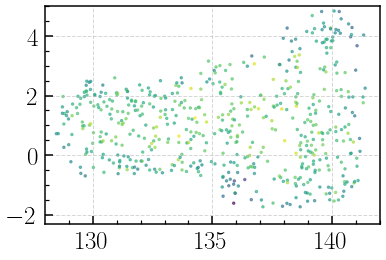

In [88]:
plt.scatter(cam_s16a['ra'], cam_s16a['dec'], s=6, alpha=0.6, c=np.log10(cam_s16a['n_s_tot']))

plt.xlim(128, 142)
plt.ylim(-2.3, 5)

(-2.3, 5.0)

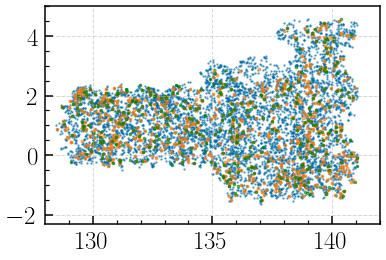

In [9]:
plt.scatter(topn_ids['ra'][topn_ids['flag_hsc']], topn_ids['dec'][topn_ids['flag_hsc']], s=2, alpha=0.5)
plt.scatter(topn_ids['ra'][topn_ids['flag_redm_hsc']], topn_ids['dec'][topn_ids['flag_redm_hsc']], s=8, alpha=0.6)
plt.scatter(topn_ids['ra'][topn_ids['flag_cam']], topn_ids['dec'][topn_ids['flag_cam']], s=6, alpha=0.6, c='green')

plt.xlim(128, 142)
plt.ylim(-2.3, 5)

(-6.8, -1.5)

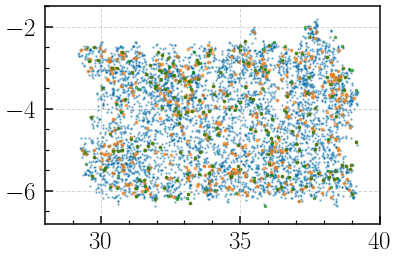

In [10]:
plt.scatter(topn_ids['ra'][topn_ids['flag_hsc']], topn_ids['dec'][topn_ids['flag_hsc']], s=2, alpha=0.4)
plt.scatter(topn_ids['ra'][topn_ids['flag_redm_hsc']], topn_ids['dec'][topn_ids['flag_redm_hsc']], s=8, alpha=0.6)
plt.scatter(topn_ids['ra'][topn_ids['flag_cam']], topn_ids['dec'][topn_ids['flag_cam']], s=6, alpha=0.6, c='green')

plt.xlim(28, 40)
plt.ylim(-6.8, -1.5)

(-1.9, 1.5)

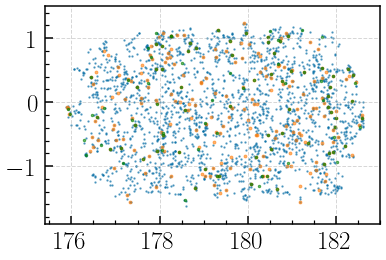

In [11]:
plt.scatter(topn_ids['ra'][topn_ids['flag_hsc']], topn_ids['dec'][topn_ids['flag_hsc']], s=2, alpha=0.5)
plt.scatter(topn_ids['ra'][topn_ids['flag_redm_hsc']], topn_ids['dec'][topn_ids['flag_redm_hsc']], s=8, alpha=0.6)
plt.scatter(topn_ids['ra'][topn_ids['flag_cam']], topn_ids['dec'][topn_ids['flag_cam']], s=6, alpha=0.6, c='green')

plt.xlim(175.4, 183)
plt.ylim(-1.9, 1.5)

(-1.9, 1.5)

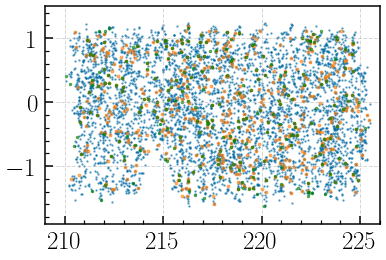

In [12]:
plt.scatter(topn_ids['ra'][topn_ids['flag_hsc']], topn_ids['dec'][topn_ids['flag_hsc']], s=2, alpha=0.5)
plt.scatter(topn_ids['ra'][topn_ids['flag_redm_hsc']], topn_ids['dec'][topn_ids['flag_redm_hsc']], s=8, alpha=0.6)
plt.scatter(topn_ids['ra'][topn_ids['flag_cam']], topn_ids['dec'][topn_ids['flag_cam']], s=6, alpha=0.6, c='green')

plt.xlim(209, 226)
plt.ylim(-1.9, 1.5)

(-0.9, 2.5)

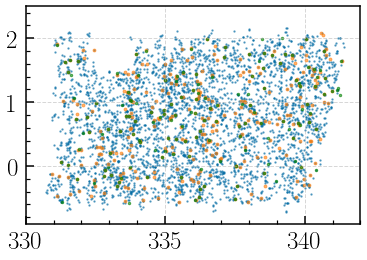

In [13]:
plt.scatter(topn_ids['ra'][topn_ids['flag_hsc']], topn_ids['dec'][topn_ids['flag_hsc']], s=2, alpha=0.5)
plt.scatter(topn_ids['ra'][topn_ids['flag_redm_hsc']], topn_ids['dec'][topn_ids['flag_redm_hsc']], s=8, alpha=0.6)
plt.scatter(topn_ids['ra'][topn_ids['flag_cam']], topn_ids['dec'][topn_ids['flag_cam']], s=6, alpha=0.6, c='green')

plt.xlim(330, 342)
plt.ylim(-0.9, 2.5)

(42.0, 44.6)

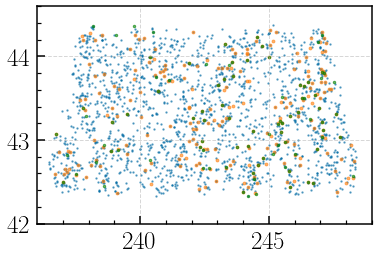

In [14]:
plt.scatter(topn_ids['ra'][topn_ids['flag_hsc']], topn_ids['dec'][topn_ids['flag_hsc']], s=2, alpha=0.5)
plt.scatter(topn_ids['ra'][topn_ids['flag_redm_hsc']], topn_ids['dec'][topn_ids['flag_redm_hsc']], s=8, alpha=0.6)
plt.scatter(topn_ids['ra'][topn_ids['flag_cam']], topn_ids['dec'][topn_ids['flag_cam']], s=6, alpha=0.6, c='green')

plt.xlim(236, 249)
plt.ylim(42, 44.6)

### Basic information of the sample

#### HSC Massive galaxies

In [16]:
hsc_use = hsc[hsc['flag'] > 0]

hsc_spec_z = hsc_use['z_spec'] > 0

print("Among all {:d} galaxies, {:d} have auseful spec-z".format(len(hsc_use), hsc_spec_z.sum()))

Among all 24051 galaxies, 15558 have auseful spec-z


In [17]:
mass_flag_1 = (hsc_use['logm_100'] >= 11.5)

print("Among the {:d} galaxies with logM*100 > 11.5, {:d} have spec-z".format(
    mass_flag_1.sum(), (mass_flag_1 & hsc_spec_z).sum()))

Among the 4848 galaxies with logM*100 > 11.5, 4429 have spec-z


In [19]:
mass_flag_2 = (hsc_use['logm_100'] >= 11.6)

print("Among the {:d} galaxies with logM*100 > 11.6, {:d} have spec-z".format(
    mass_flag_2.sum(), (mass_flag_2 & hsc_spec_z).sum()))

Among the 2299 galaxies with logM*100 > 11.6, 2190 have spec-z


#### HSC redMaPPer clusters

In [23]:
redm_use = redm_hsc[redm_hsc['flag'] > 0]

redm_spec_z = redm_use['z_spec'] > 0

print("Among all {:d} centrals, {:d} have auseful spec-z".format(len(redm_use), redm_spec_z.sum()))

Among all 2409 galaxies, 1623 have auseful spec-z


In [27]:
lambda_1 = redm_use['lambda'] >= 20

print("Among all {:d} centrals in lambda > 20 clusters, {:d} have auseful spec-z".format(lambda_1.sum(), (lambda_1 & redm_spec_z).sum()))

Among all 227 centrals in lambda > 20 clusters, 186 have auseful spec-z


In [28]:
z_mask = ((redm_use['z_spec'] >= 0.19) & (redm_use['z_spec'] <= 0.52))

print("Photo-z bias", np.median(redm_use['z_lambda'][z_mask] - redm_use['z_spec'][z_mask]))

print("Photo-z scattter", np.nanstd((redm_use['z_lambda'][z_mask] - redm_use['z_spec'][z_mask]) / (1. + redm_use['z_spec'][z_mask])))

print("Outlier fraction", ((np.abs(redm_use['z_lambda'][z_mask] - redm_use['z_spec'][z_mask]) / np.std(redm_use['z_lambda'][z_mask] - redm_use['z_spec'][z_mask])) > 4).sum() / z_mask.sum())

Photo-z bias 0.0011574625929871019
Photo-z scattter 0.011156569999977743
Outlier fraction 0.0061614294516327784


In [29]:
z_mask = ((redm_use['z_spec'] >= 0.19) & (redm_use['z_spec'] <= 0.52) & (redm_use['lambda'] >= 20))

print("Photo-z bias", np.median(redm_use['z_lambda'][z_mask] - redm_use['z_spec'][z_mask]))

print("Photo-z scattter", np.nanstd((redm_use['z_lambda'][z_mask] - redm_use['z_spec'][z_mask]) / (1. + redm_use['z_spec'][z_mask])))

print("Outlier fraction", ((np.abs(redm_use['z_lambda'][z_mask] - redm_use['z_spec'][z_mask]) / np.std(redm_use['z_lambda'][z_mask] - redm_use['z_spec'][z_mask])) > 4).sum() / z_mask.sum())

Photo-z bias 0.0008285938115157876
Photo-z scattter 0.006735300206883765
Outlier fraction 0.005376344086021506


In [32]:
p_cen_1 = redm_use['p_cen_1'] >= 0.7
p_cen_2 = redm_use['p_cen_1'] >= 0.8

print("Centrals with P_cen_1 >= 0.7: {:d} - {:5.2f}".format(p_cen_1.sum(), p_cen_1.sum() / len(redm_use)))
print("Centrals with P_cen_1 >= 0.8: {:d} - {:5.2f}".format(p_cen_2.sum(), p_cen_2.sum() / len(redm_use)))

Centrals with P_cen_1 >= 0.7: 1849 -  0.77
Centrals with P_cen_1 >= 0.8: 1585 -  0.66


#### SDSS redMaPPer clusters

In [34]:
redm_sdss_use = redm_sdss[redm_sdss['flag'] > 0]

print(len(redm_sdss_use))

364


#### CAMIRA clusters

In [35]:
cam_use = cam_s16a[cam_s16a['flag'] > 0]

cam_spec_z = cam_use['z_spec'] > 0

print("Among all {:d} centrals, {:d} have auseful spec-z".format(len(cam_use), cam_spec_z.sum()))

Among all 998 centrals, 725 have auseful spec-z


In [36]:
nmem_1 = cam_use['n_mem'] >= 20

print("Among all {:d} centrals in n_mem > 20 clusters, {:d} have auseful spec-z".format(nmem_1.sum(), (nmem_1 & cam_spec_z).sum()))

Among all 263 centrals in n_mem > 20 clusters, 212 have auseful spec-z


In [39]:
z_mask = ((cam_use['z_spec'] >= 0.19) & (cam_use['z_spec'] <= 0.52))

print("Photo-z bias", np.median(cam_use['z_cl'][z_mask] - cam_use['z_spec'][z_mask]))

print("Photo-z scattter", np.nanstd((cam_use['z_cl'][z_mask] - cam_use['z_spec'][z_mask]) / (1. + cam_use['z_spec'][z_mask])))

print("Outlier fraction", ((np.abs(cam_use['z_cl'][z_mask] - cam_use['z_spec'][z_mask]) / np.std(cam_use['z_cl'][z_mask] - cam_use['z_spec'][z_mask])) > 4).sum() / z_mask.sum())

Photo-z bias -0.004240602059906007
Photo-z scattter 0.01287214710131031
Outlier fraction 0.013793103448275862


In [40]:
z_mask = ((cam_use['z_spec'] >= 0.19) & (cam_use['z_spec'] <= 0.52) & (cam_use['n_mem'] >= 20))

print("Photo-z bias", np.median(cam_use['z_cl'][z_mask] - cam_use['z_spec'][z_mask]))

print("Photo-z scattter", np.nanstd((cam_use['z_cl'][z_mask] - cam_use['z_spec'][z_mask]) / (1. + cam_use['z_spec'][z_mask])))

print("Outlier fraction", ((np.abs(cam_use['z_cl'][z_mask] - cam_use['z_spec'][z_mask]) / np.std(cam_use['z_cl'][z_mask] - cam_use['z_spec'][z_mask])) > 4).sum() / z_mask.sum())

Photo-z bias -0.0036436470313873093
Photo-z scattter 0.008611559203417989
Outlier fraction 0.009433962264150943


### Test the TopN test -- Outskirt mass between 50 to 100 kpc v.s. redMaPPer richness

In [74]:
# Lensing data using medium photo-z quality cut
s16a_lensing = os.path.join(topn_dir, 's16a_weak_lensing_medium.hdf5')

# Random
s16a_rand = Table.read(s16a_lensing, path='random')



In [77]:
# TopN bins
topn_bins = Table.read(os.path.join(jb_dir, 'data', 'bins', 'topn_bins.fits'))

# Tablulated simulation results
sim_cat = Table.read(os.path.join(jb_dir, 'data', 'simulation', 'sim_dsigma_scatter_merge.fits'))

In [78]:
topn_redm = wlensing.gather_topn_dsigma_profiles(
    redm_use, s16a_rand, topn_bins, 'lambda', n_rand=100000, n_boot=200, verbose=True)

#hsc_use = catalog.add_outer_mass(hsc_use, 'logm_50', 'logm_100')
topn_mout = wlensing.gather_topn_dsigma_profiles(
    hsc_use, s16a_rand, topn_bins, 'logm_50_100', n_rand=100000, n_boot=200, verbose=True, n_jk=40)


# Using column: lambda
# Bin 1:     0 -    52
# Bin 2:    53 -   248
# Bin 3:   224 -   817
# Bin 4:   818 -  1860

# Using column: logm_50_100
# Bin 1:     0 -    49
# Bin 2:    50 -   235
# Bin 3:   236 -   862
# Bin 4:   863 -  1963


# Dealing with Bin: 1
# Dealing with Bin: 2
# Dealing with Bin: 3
# Dealing with Bin: 4
# Dealing with Bin: 1
# Dealing with Bin: 2
# Dealing with Bin: 3
# Dealing with Bin: 4


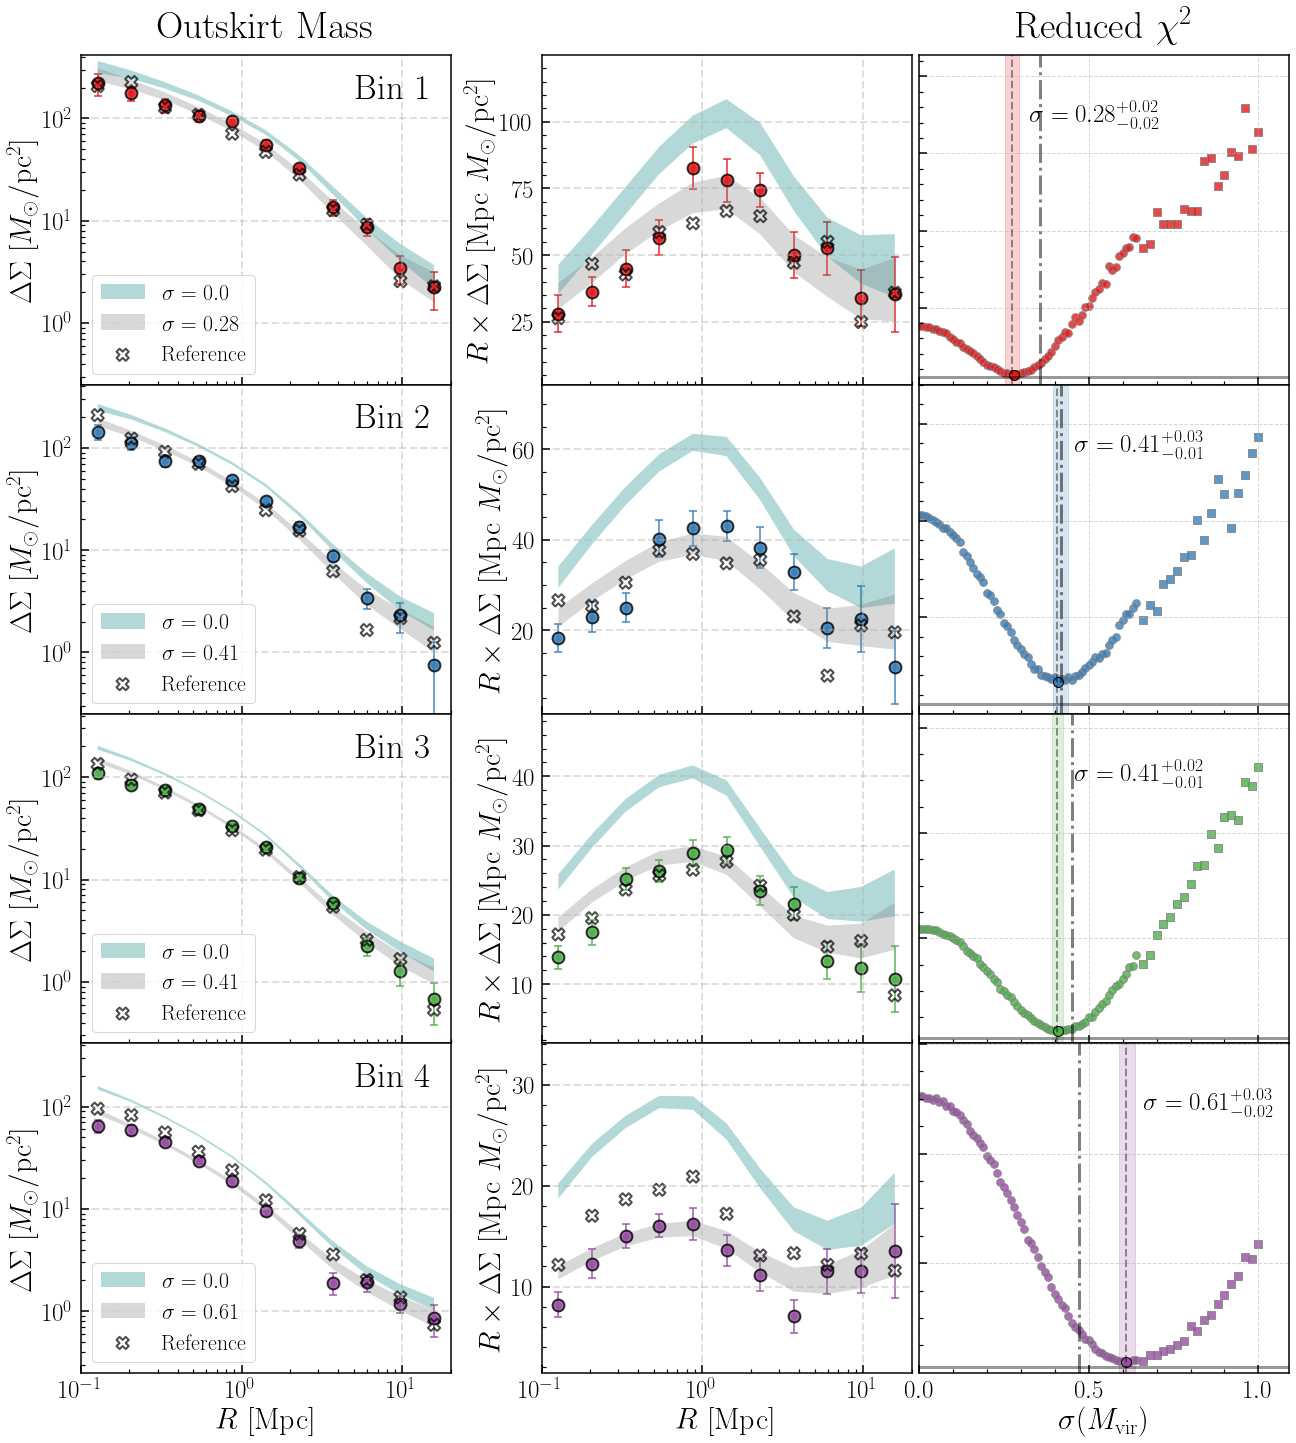

In [79]:
topn_redm_sum = scatter.compare_model_dsigma(
    topn_redm, sim_cat, model_err=True, poly=True, verbose=True)

topn_mout_sum = scatter.compare_model_dsigma(
    topn_mout, sim_cat, model_err=True, poly=True, verbose=True)

fig = visual.sum_plot_topn(
    topn_redm_sum, r'$\rm Outskirt\ Mass$', note=None, cov_type='jk', ref_tab=topn_mout_sum)

### Value added the HSC massive galaxy catalog

#### Average axis ratios within different radial ranges

In [109]:
ba_0 = [profile.estimate_average_ba(gal, r_min=10, r_max=20, use_weight=True) for gal in hsc]
ba_1 = [profile.estimate_average_ba(gal, r_min=10, r_max=30, use_weight=True) for gal in hsc]
ba_2 = [profile.estimate_average_ba(gal, r_min=30, r_max=50, use_weight=True) for gal in hsc]
ba_3 = [profile.estimate_average_ba(gal, r_min=40, r_max=70, use_weight=True) for gal in hsc]

In [110]:
hsc.add_column(Column(data=ba_0, name='ba_0'))
hsc.add_column(Column(data=ba_1, name='ba_1'))
hsc.add_column(Column(data=ba_2, name='ba_2'))
hsc.add_column(Column(data=ba_3, name='ba_3'))

#### Add extrapolated stellar mass

In [150]:
# Extrapolate to 150 kpc
logm_extra = []
r_extra = [120., 150., 200., 300.,]

sample = hsc

for i in range(len(sample)):
    gal = hsc_massive[i]
    if gal['logm_100'] >= 11.25:
        if gal['logm_100'] >= 11.50:
            q_outskirt = gal['ba_3']
        else:
            q_outskirt = gal['ba_2']
            
        _, sbp = profile.get_extra_masses(
            gal, rmin=None, rmax=None, r_extra=r_extra, q_outskirt=q_outskirt)
    else:
        sbp = np.full(len(r_extra), gal['logm_max'])
        
    logm_extra.append(sbp)
    update_progress(i / len(sample))
    
logm_extra_arr = np.asarray(logm_extra)

logm_120_extra = np.asarray(logm_extra)[:, 0]
logm_150_extra = np.asarray(logm_extra)[:, 1]
logm_200_extra = np.asarray(logm_extra)[:, 2]
logm_300_extra = np.asarray(logm_extra)[:, 3]

Progress: [####################] 100.0%


In [170]:
hsc.add_column(Column(data=logm_120_extra, name='logm_extra_120'))
hsc.add_column(Column(data=logm_150_extra, name='logm_extra_150'))
hsc.add_column(Column(data=logm_200_extra, name='logm_extra_200'))
hsc.add_column(Column(data=logm_300_extra, name='logm_extra_300'))

#### Add extra outskirt stellar mass

In [171]:
r_kpc = profile.RKPC_COMMON

r_mask = (r_kpc >= 10.0) & (r_kpc <= 120.)

In [175]:
# Add a few stellar mass
hsc['logm_60'] = np.asarray(
    [interpolate.interp1d(np.log10(r_kpc), hsc['cog'][i], kind='slinear')(
        np.log10(60.)) for i in range(len(hsc))])

hsc['logm_r50'] = np.asarray(
    [interpolate.interp1d(np.log10(r_kpc), hsc['cog'][i], kind='slinear')(
        np.log10(hsc['r50_100'][i])) for i in range(len(hsc))])

hsc['logm_r50_half'] = np.asarray(
    [interpolate.interp1d(np.log10(r_kpc), hsc['cog'][i], kind='slinear')(
        np.log10(hsc['r50_100'][i] * 1.5)) for i in range(len(hsc))])

hsc['logm_2_r50'] = np.asarray(
    [interpolate.interp1d(np.log10(r_kpc), hsc['cog'][i], kind='slinear')(
        np.log10(hsc['r50_100'][i] * 2.0)) for i in range(len(hsc))])

hsc['logm_3_r50'] = np.asarray(
    [interpolate.interp1d(np.log10(r_kpc), hsc['cog'][i], kind='slinear')(
        np.log10(hsc['r50_100'][i] * 3.0)) for i in range(len(hsc))])

hsc['logm_4_r50'] = np.asarray(
    [interpolate.interp1d(np.log10(r_kpc), hsc['cog'][i], kind='slinear')(
        np.log10(hsc['r50_100'][i] * 4.0)) for i in range(len(hsc))])

hsc['logm_5_r50'] = np.asarray(
    [interpolate.interp1d(np.log10(r_kpc), hsc['cog'][i], kind='slinear')(
        np.log10(hsc['r50_100'][i] * 5.0)) for i in range(len(hsc))])

hsc['logm_6_r50'] = np.asarray(
    [interpolate.interp1d(np.log10(r_kpc), hsc['cog'][i], kind='slinear')(
        np.log10(hsc['r50_100'][i] * 6.0)) for i in range(len(hsc))])

# Add outskirt stellar masses
hsc = catalog.add_outer_mass(hsc, 'logm_10', 'logm_100')
hsc = catalog.add_outer_mass(hsc, 'logm_30', 'logm_100')
hsc = catalog.add_outer_mass(hsc, 'logm_40', 'logm_100')
hsc = catalog.add_outer_mass(hsc, 'logm_50', 'logm_100')
hsc = catalog.add_outer_mass(hsc, 'logm_60', 'logm_100')
hsc = catalog.add_outer_mass(hsc, 'logm_50', 'logm_150')
hsc = catalog.add_outer_mass(hsc, 'logm_60', 'logm_150')
hsc = catalog.add_outer_mass(hsc, 'logm_75', 'logm_150')

hsc = catalog.add_outer_mass(hsc, 'logm_40', 'logm_120')
hsc = catalog.add_outer_mass(hsc, 'logm_50', 'logm_120')
hsc = catalog.add_outer_mass(hsc, 'logm_60', 'logm_120')
hsc = catalog.add_outer_mass(hsc, 'logm_75', 'logm_120')

hsc = catalog.add_outer_mass(hsc, 'logm_50', 'logm_extra_120', name='logm_50_120_extra')
hsc = catalog.add_outer_mass(hsc, 'logm_50', 'logm_extra_150', name='logm_50_150_extra')
hsc = catalog.add_outer_mass(hsc, 'logm_50', 'logm_extra_200', name='logm_50_200_extra')
hsc = catalog.add_outer_mass(hsc, 'logm_50', 'logm_extra_300', name='logm_50_300_extra')

hsc = catalog.add_outer_mass(hsc, 'logm_2_r50', 'logm_4_r50', name='logm_2_4_r50')
hsc = catalog.add_outer_mass(hsc, 'logm_2_r50', 'logm_5_r50', name='logm_2_4_r50')
hsc = catalog.add_outer_mass(hsc, 'logm_2_r50', 'logm_6_r50', name='logm_2_6_r50')

hsc = catalog.add_outer_mass(hsc, 'logm_3_r50', 'logm_4_r50', name='logm_3_4_r50')
hsc = catalog.add_outer_mass(hsc, 'logm_3_r50', 'logm_5_r50', name='logm_3_5_r50')
hsc = catalog.add_outer_mass(hsc, 'logm_3_r50', 'logm_6_r50', name='logm_3_6_r50')
hsc = catalog.add_outer_mass(hsc, 'logm_4_r50', 'logm_6_r50', name='logm_4_6_r50')

#### Write a new version with extra information

In [178]:
hsc.write(s16a_precompute_med, path='hsc_extra', overwrite=True, append=True, serialize_meta=True)